Use ccl to compute theory curve for galaxies

In [1]:
import numpy as np
import pylab as pl
from astropy.io import fits
import healpy as hp

In [2]:
# grab a theory curve:
omega_M = 0.3147
omega_L = 0.6853
omega_B = 0.04904
h = 0.6731
w = -1.0
ns = 0.9655
sigma_8 = 0.83

# grab CCL theory curve:


In [3]:
import pyccl as ccl
ccl.gsl_params.LENSING_KERNEL_SPLINE_INTEGRATION = True
cosmo_ccl = ccl.Cosmology(Omega_c = omega_M-omega_B, Omega_b = omega_B, h = h, 
                          sigma8 = sigma_8, n_s = ns)

In [4]:
bias_z = np.loadtxt("../bias_dc2.txt")

In [4]:
# load n(z), b(z)
import yaml

root = '/pscratch/sd/q/qhang/roman-rubin-sims/baselinev3.3/'
packed_stats_fzb_source={}
for year in [1,3,5]:
    fname=root+f'y{year}/fzb/test-pz-with-i-band-coadd-Y{year}-snr-10.0-source-meanApsf-theta_eff.yml'
    with open(fname, "r") as stream:
        packed_stats_fzb_source[year]=yaml.load(stream,Loader=yaml.Loader)
        
# take some tomo graphic binning:
year = 5
nz_tomo = {}
nz_tomo_tot = 0
for kk in range(5):
    nz = packed_stats_fzb_source[year]["tomo-%d"%(kk+1)]["nztot"]
    y=nz[:,1]/np.sum(nz[:,1])/(nz[1,0]-nz[0,0])
    nz_tomo[kk] = np.c_[nz[:,0], y]
    nz_tomo_tot += nz[:,1]
nz_tomo_tot = nz_tomo_tot/sum(nz_tomo_tot)/(nz[1,0]-nz[0,0])

In [ ]:
# interp
bias_z_int = np.interp(nz_tomo[kk][:,0], bias_z[:,0], bias_z[:,1])

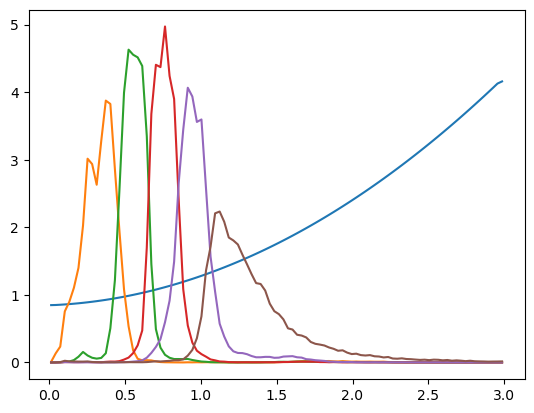

In [9]:
pl.plot(nz_tomo[kk][:,0],bias_z_int)
for ii in range(5):
    pl.plot(nz_tomo[ii][:,0],nz_tomo[ii][:,1])

In [ ]:
root="/pscratch/sd/q/qhang/desi-lya/"
ell=np.arange(1,1001)
clth = np.zeros((1001,5))
for ii in range(5):
    
    #fin = np.loadtxt(root+f"NofZ-lens-tomo-{lens_bin}-fzb.dat")
    #finzbin = fin[:,0]
    #finzz = (finzbin[1:]+ finzbin[:-1])/2.
    #finnz = fin[:-1,1]
    
    # try ccl:
    nz = nz_tomo[ii][:,1]
    clu1 = ccl.NumberCountsTracer(cosmo_ccl, has_rsd=False, dndz=(nz_tomo[ii][:,0], nz), 
                                          bias=(nz_tomo[ii][:,0],bias_z_int))

    tmp=ccl.angular_cl(cosmo_ccl, clu1, clu1, ell)
    clth[:,ii] = np.append(0, tmp)

fname = root+"clgg-theory.txt"
np.savetxt(fname, clth)

In [10]:
# grab theory form n(z):
saveroot = "/pscratch/sd/q/qhang/desi-lya/"
galnz = np.loadtxt(saveroot + "gal-nzcount-truezbin.txt")

zz = (galnz[1:,0] +  galnz[:-1,0])/2.

bias_z_int = np.interp(zz, bias_z[:,0], bias_z[:,1])

In [11]:
root="/pscratch/sd/q/qhang/desi-lya/"
ell=np.arange(1,1001)
clth = np.zeros((1001,5))
for ii in range(5):

    nz = galnz[:-1,ii+1]
    clu1 = ccl.NumberCountsTracer(cosmo_ccl, has_rsd=True, dndz=(zz, nz), 
                                          bias=(zz,bias_z_int))

    tmp=ccl.angular_cl(cosmo_ccl, clu1, clu1, ell)
    clth[:,ii] = np.append(0, tmp)

fname = root+"clgg-theory-truezbin.txt"
np.savetxt(fname, clth)

# Correlation in bins:

In [5]:
# load redshift distributions for phot and lya sample (assume tophat):
# mock 0
root="/pscratch/sd/q/qhang/desi-lya/results/run-0/"
fname = root + "catalogue/nz-unknown-zmin-1.8-zmax-3.0.txt"
nz_phot = np.loadtxt(fname)
print(nz_phot.shape)
# both 20 bins and 40 bins - use 40 bins to find the bias evolution - > apply to 20 bin case

(80, 2)


In [6]:
zsamp = np.linspace(0,3,200)
dz = zsamp[1]-zsamp[0]
binedges = np.linspace(2,3,41)
nz_phot_interp= np.interp(zsamp, nz_phot[:,0], nz_phot[:,1])
nz_phot_interp = nz_phot_interp/sum(nz_phot_interp)/dz
ell=np.arange(1,3001)
theta = np.linspace(10/60, 30/60, 10)#degrees
zbins = (binedges[1:] +  binedges[:-1])/2.

In [36]:
# auto-correlation:
w_ss = np.zeros(len(binedges)-1)
for ii in range(len(binedges)-1):
    zsamp_lyaf = np.linspace(binedges[ii],binedges[ii+1],50)
    dz = zsamp_lyaf[1]-zsamp_lyaf[0]
    nz_lyaf = np.ones(len(zsamp_lyaf))
    nz_lyaf = nz_lyaf/sum(nz_lyaf)/dz
    
    clu2 = ccl.NumberCountsTracer(cosmo_ccl, has_rsd=False, dndz=(zsamp_lyaf, nz_lyaf), 
                                          bias=(zsamp_lyaf, np.ones(len(zsamp_lyaf))))

    cell=ccl.angular_cl(cosmo_ccl, clu2, clu2, ell)
    w1 = ccl.correlations.correlation(cosmo_ccl, ell=ell, C_ell=cell, theta=theta)

    # take avg of angles:
    w_ss[ii] = np.mean(w1)

In [54]:
data_wss = np.loadtxt("mock0-wss-40bins-baseline-raw.txt")
data_wss20 = np.loadtxt("mock0-wss-20bins-baseline-raw.txt")

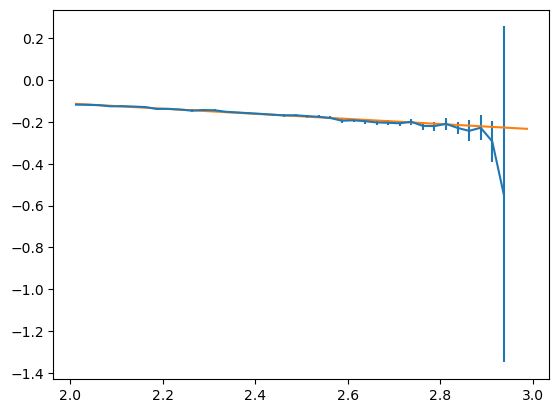

In [50]:
blya_meas = - np.sqrt(data_wss[:,1]/w_ss)
blya_meas_err = abs((data_wss[:,2]/data_wss[:,1])*blya_meas)
pl.errorbar(zbins, blya_meas, yerr=blya_meas_err)
# fit a straight line through the curves:
poly=np.polyfit(zbins[:-2], blya_meas[:-2], 1, w=1/blya_meas_err[:-2])
pl.plot(zbins, zbins*poly[0] + poly[1])

In [66]:
def lya_bias_input(z):
    alpha = 2.9
    bias_zref = -0.1352
    zref = 2.33
    bias_z = bias_zref * ((1 + z)/(1 + zref))**alpha

    return bias_z

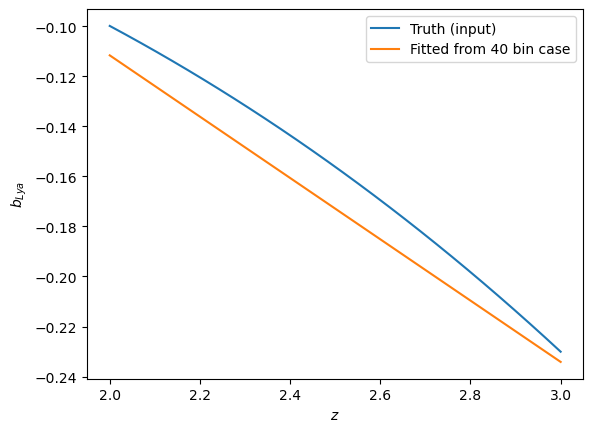

In [77]:
# load the Lya bias:
zz = np.linspace(2,3,30)
pl.plot(zz, lya_bias_input(zz),label="Truth (input)")
pl.plot(zz, -0.1224972*zz + 0.13334162, label="Fitted from 40 bin case")
# fitted value is about 10% larger
pl.xlabel("$z$")
pl.ylabel("$b_{Lya}$")
pl.legend()

In [110]:
print(poly)

[-0.1224972   0.13334162]


In [101]:
# auto-correlation:
w_ss_fitted = np.zeros(len(binedges)-1)
for ii in range(len(binedges)-1):
    zsamp_lyaf = np.linspace(binedges[ii],binedges[ii+1],50)
    dz = zsamp_lyaf[1]-zsamp_lyaf[0]
    nz_lyaf = np.ones(len(zsamp_lyaf))
    nz_lyaf = nz_lyaf/sum(nz_lyaf)/dz
    
    clu2 = ccl.NumberCountsTracer(cosmo_ccl, has_rsd=False, dndz=(zsamp_lyaf, nz_lyaf), 
                                          bias=(zsamp_lyaf, zsamp_lyaf*poly[0] + poly[1]))

    cell=ccl.angular_cl(cosmo_ccl, clu2, clu2, ell)
    w1 = ccl.correlations.correlation(cosmo_ccl, ell=ell, C_ell=cell, theta=theta)

    # take avg of angles:
    w_ss_fitted[ii] = np.mean(w1)

In [59]:
# now compute the 20-bin auto-correlation and see if we get consistent result:
binedges20 = np.linspace(2,3,21)
zbins20 = (binedges20[1:]+binedges20[:-1])/2.
# auto-correlation:
w_ss20 = np.zeros(len(binedges20)-1)
for ii in range(len(binedges20)-1):
    zsamp_lyaf = np.linspace(binedges20[ii],binedges20[ii+1],50)
    dz = zsamp_lyaf[1]-zsamp_lyaf[0]
    nz_lyaf = np.ones(len(zsamp_lyaf))
    nz_lyaf = nz_lyaf/sum(nz_lyaf)/dz
    
    clu2 = ccl.NumberCountsTracer(cosmo_ccl, has_rsd=False, dndz=(zsamp_lyaf, nz_lyaf), 
                                          bias=(zsamp_lyaf, zsamp_lyaf*poly[0] + poly[1]))

    cell=ccl.angular_cl(cosmo_ccl, clu2, clu2, ell)
    w1 = ccl.correlations.correlation(cosmo_ccl, ell=ell, C_ell=cell, theta=theta)

    # take avg of angles:
    w_ss20[ii] = np.mean(w1)

Text(0.5, 1.0, '$\\theta=[10,30]$ arcmin, 20 bins')

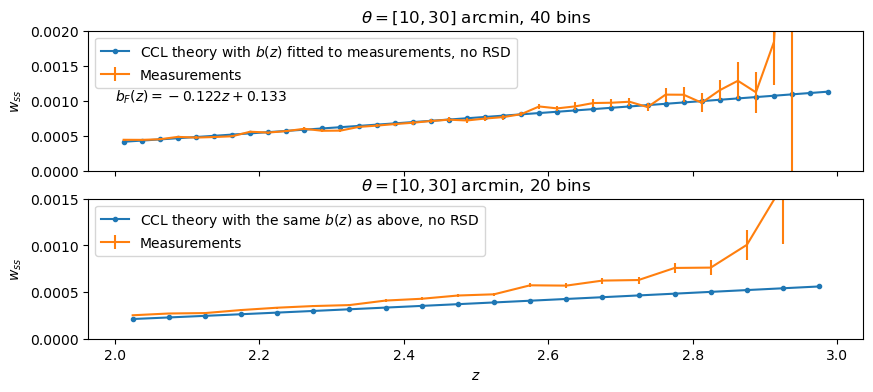

In [134]:
fig,axarr=pl.subplots(2,figsize=[10,4],sharex=True)
pl.sca(axarr[0])
pl.plot(zbins, w_ss_fitted, '.-',label="CCL theory with $b(z)$ fitted to measurements, no RSD")
pl.errorbar(data_wss[:,0], data_wss[:,1],yerr=data_wss[:,2], label="Measurements")
pl.ylim([0,0.002])
pl.ylabel("$w_{ss}$")
pl.legend()
pl.title("$\\theta=[10,30]$ arcmin, 40 bins")
pl.text(2,0.001,f"$b_F(z) = {round(poly[0],3)}z + {round(poly[1],3)}$")

pl.sca(axarr[1])
pl.plot(zbins20, w_ss20,'.-',label="CCL theory with the same $b(z)$ as above, no RSD")
pl.errorbar(data_wss20[:,0], data_wss20[:,1],yerr=data_wss20[:,2], label="Measurements")
pl.xlabel("$z$")
pl.ylabel("$w_{ss}$")
pl.ylim([0,0.0015])
pl.legend()
pl.title("$\\theta=[10,30]$ arcmin, 20 bins")

# $w_{pp}$

In [10]:
# use scales [10,30] and [30,50]
data_wpp10 = np.loadtxt("mock0-wpp-10bins-baseline.txt")
data_wpp20 = np.loadtxt("mock0-wpp-20bins-baseline.txt")
data_wpp20 = np.c_[data_wpp20[:,0], data_wpp20[:,3:5], data_wpp20[:,7:]]
data_wpp = np.loadtxt("mock0-wpp-40bins-baseline.txt")
data_wpp = np.c_[data_wpp[:,0], data_wpp[:,3:5], data_wpp[:,7:]]

In [7]:
# load bias evolution of the input:
zsamp = np.linspace(1.8,3.0,301)
dz = zsamp[1]-zsamp[0]
zz = (zsamp[1:] + zsamp[:-1])/2.
bz_interp = np.interp(zz, bias_z[:,0], bias_z[:,1])

In [8]:
# auto-correlation:
nbins = [10,20,40]
theta = [np.linspace(10/60, 30/60, 10), np.linspace(30/60, 50/60, 10)]
binedges = [np.linspace(2,3,n+1) for n in nbins]
nside=1024
ell = np.arange(3*nside)

WPP_m = []
WPP_w = []
WPP_theta = []
for tt in range(len(theta)):
    w_pp_mean = [np.zeros(len(l)-1) for l in binedges]
    w_pp_weight = [np.zeros(len(l)-1) for l in binedges]
    w_pp_theta = [np.zeros((10,len(l)-1)) for l in binedges]
    for jj in range(len(nbins)):
        for ii in range(len(binedges[jj])-1):
            zsamp = np.linspace(binedges[jj][ii],binedges[jj][ii+1],50)
            dz = zsamp[1]-zsamp[0]
            nz = np.ones(len(zsamp))
            nz = nz/sum(nz)/dz
            bz_interp = np.interp(zsamp, bias_z[:,0], bias_z[:,1])
            
            clu2 = ccl.NumberCountsTracer(cosmo_ccl, has_rsd=False, dndz=(zsamp, nz), 
                                                  bias=(zsamp, bz_interp))
        
            cell=ccl.angular_cl(cosmo_ccl, clu2, clu2, ell)
            w1 = ccl.correlations.correlation(cosmo_ccl, ell=ell, C_ell=cell, theta=theta[tt])
        
            # take avg of angles:
            weights = theta[tt]**2
            weights = weights/sum(weights)
            w_pp_mean[jj][ii] = np.mean(w1)
            w_pp_weight[jj][ii] = np.sum(w1*weights)
            w_pp_theta[jj][:,ii] = w1
    WPP_w.append(w_pp_weight)
    WPP_m.append(w_pp_mean)
    WPP_theta.append(w_pp_theta)

In [ ]:
# save these theory

<ErrorbarContainer object of 3 artists>

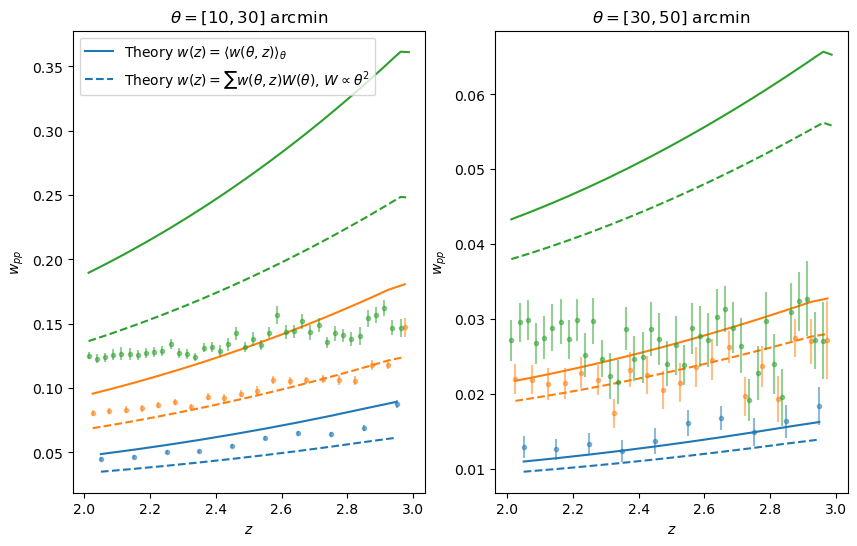

In [49]:
# produce a plot showing the wp using input bias curve and the measurements:
theta_min = [10,30]
theta_max = [30,50]
fig,axarr=pl.subplots(1,2,figsize=[10,6],sharex=True)
for tt in range(len(theta)):
    pl.sca(axarr[tt])
    w_pp_mean = WPP_m[tt]
    w_pp_weight = WPP_w[tt]
    for jj in range(len(nbins)):
        if jj==0:
            label1="Theory $w(z) = \\langle w(\\theta,z) \\rangle_{\\theta}$"
            label2="Theory $w(z) = \\sum w(\\theta,z) W(\\theta),\, W\\propto \\theta^2$"
        else:
            label1=""
            label2=""
        zbins = (binedges[jj][1:] + binedges[jj][:-1])/2.
        pl.plot(zbins, w_pp_mean[jj],'-',color=f'C{jj}',label=label1)       
        pl.plot(zbins, w_pp_weight[jj],'--',color=f'C{jj}',label=label2)
    pl.title(f"$\\theta = [{theta_min[tt]},{theta_max[tt]}]$ arcmin")
    pl.xlabel("$z$")
    pl.ylabel("$w_{pp}$")
pl.sca(axarr[0])
alpha=0.5
pl.errorbar(data_wpp10[:,0],data_wpp10[:,1],yerr=data_wpp10[:,2],fmt='.',alpha=alpha)
pl.errorbar(data_wpp20[:,0],data_wpp20[:,1],yerr=data_wpp20[:,2],fmt='.',alpha=alpha)
pl.errorbar(data_wpp[:-1,0],data_wpp[:-1,1],yerr=data_wpp[:-1,2],fmt='.',alpha=alpha)
pl.legend()
pl.sca(axarr[1])
pl.errorbar(data_wpp10[:,0],data_wpp10[:,3],yerr=data_wpp10[:,4],fmt='.',alpha=alpha)
pl.errorbar(data_wpp20[:,0],data_wpp20[:,3],yerr=data_wpp20[:,4],fmt='.',alpha=alpha)
pl.errorbar(data_wpp[:-1,0],data_wpp[:-1,3],yerr=data_wpp[:-1,4],fmt='.',alpha=alpha)
#pl.yscale('log')

In [ ]:
# old code below

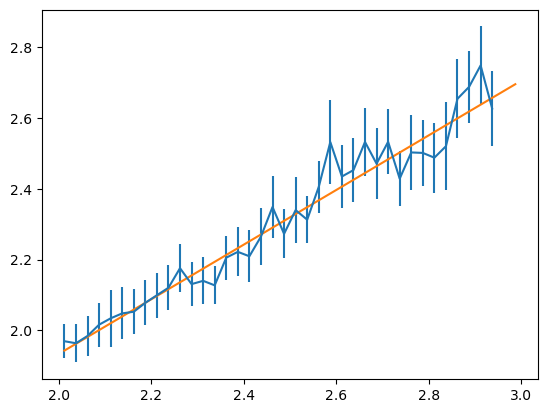

In [69]:
bp_meas = np.sqrt(data_wpp[:,1]/w_ss)
bp_meas_err = abs((data_wpp[:,2]/data_wpp[:,1])*bp_meas)
pl.errorbar(zbins[:-2], bp_meas[:-2], yerr=bp_meas_err[:-2])
# fit a straight line through the curves:
poly_pp=np.polyfit(zbins[:-2], bp_meas[:-2], 1, w=1/bp_meas_err[:-2])
pl.plot(zbins, zbins*poly_pp[0] + poly_pp[1])

Text(0.5, 0, '$z$')

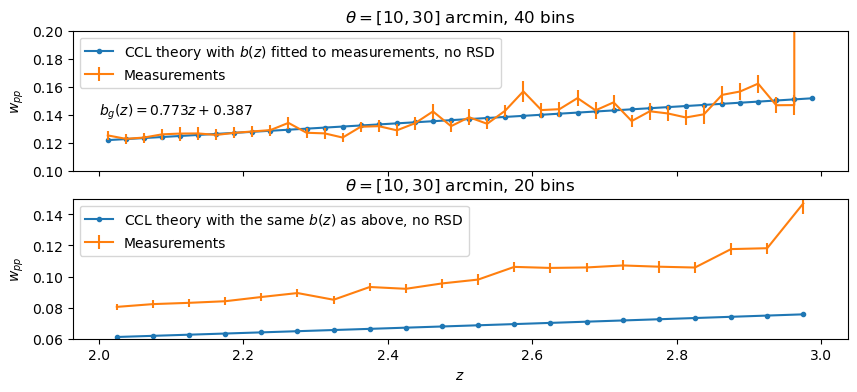

In [135]:
fig,axarr=pl.subplots(2,figsize=[10,4],sharex=True)
pl.sca(axarr[0])
pl.plot(zbins, w_pp_fitted,'.-',label="CCL theory with $b(z)$ fitted to measurements, no RSD")
pl.errorbar(data_wpp[:,0], data_wpp[:,1],yerr=data_wpp[:,2],label="Measurements")
pl.ylim([0.1,0.20])
pl.ylabel("$w_{pp}$")
pl.legend()
pl.title("$\\theta=[10,30]$ arcmin, 40 bins")
pl.text(2,0.14,f"$b_g(z) = {round(poly_pp[0],3)}z + {round(poly_pp[1],3)}$")

pl.sca(axarr[1])
pl.plot(zbins20, w_pp20,'.-',label="CCL theory with the same $b(z)$ as above, no RSD")
pl.errorbar(data_wpp20[:,0], data_wpp20[:,1], yerr=data_wpp20[:,2], label="Measurements")
pl.ylim([0.06,0.15])
pl.ylabel("$w_{pp}$")
pl.legend()
pl.title("$\\theta=[10,30]$ arcmin, 20 bins")
pl.xlabel("$z$")

### 10, 20, 40 z bins, split in theta:

In [5]:
fin0 = np.loadtxt("../codes/wpp-theta-10bins-min-10-max-30-z-10bin.txt")
fin1 = np.loadtxt("../codes/wpp-theta-10bins-min-10-max-30-z-20bin.txt")
fin2 = np.loadtxt("../codes/wpp-theta-10bins-min-10-max-30-z-40bin.txt")

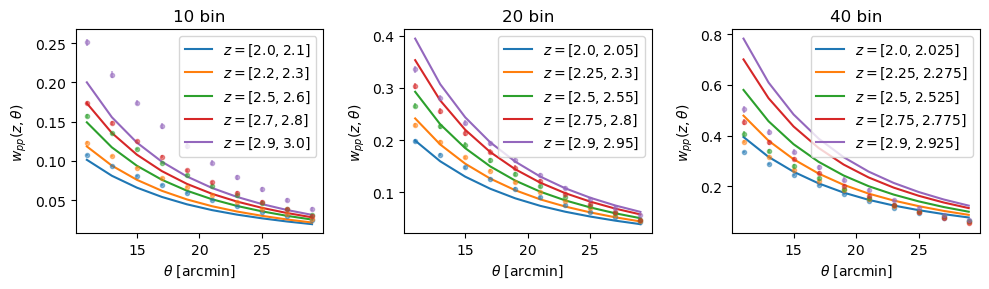

In [10]:
fig,axarr=pl.subplots(1,3,figsize=[10,3],sharex=True)
theta_bins = np.linspace(10,30,11)
theta_bincen = (theta_bins[1:] + theta_bins[:-1])/2.
pl.sca(axarr[0])
zbins = (binedges[0][1:] + binedges[0][:-1])/2.
for ii,ind in enumerate([0,2,5,7,9]):
    pl.plot(theta_bincen, WPP_theta[0][0][:,ind],label=f"$z =[{binedges[0][ind]},{binedges[0][ind+1]}]$")
    pl.errorbar(theta_bincen, fin0[:10,ind], yerr=fin0[10:,ind],color=f'C{ii}', fmt='.',alpha=0.5)
pl.legend()
pl.xlabel("$\\theta$ [arcmin]")
pl.ylabel("$w_{pp}(z, \\theta)$")
pl.title("10 bin")

pl.sca(axarr[1])
zbins = (binedges[1][1:] + binedges[1][:-1])/2.
for ii,ind in enumerate([0,5,10,15,18]):
    pl.plot(theta_bincen, WPP_theta[0][1][:,ind],label=f"$z =[{binedges[1][ind]},{binedges[1][ind+1]}]$")
    pl.errorbar(theta_bincen, fin1[:10,ind], yerr=fin1[10:,ind],color=f'C{ii}', fmt='.',alpha=0.5)
pl.legend()
pl.xlabel("$\\theta$ [arcmin]")
pl.ylabel("$w_{pp}(z, \\theta)$")
pl.title("20 bin")

pl.sca(axarr[2])
theta_bincen = (theta_bins[1:] + theta_bins[:-1])/2.
zbins = (binedges[2][1:] + binedges[2][:-1])/2.
for ii,ind in enumerate([0,10,20,30,36]):
    pl.plot(theta_bincen, WPP_theta[0][2][:,ind],label=f"$z =[{binedges[2][ind]},{binedges[2][ind+1]}]$")
    pl.errorbar(theta_bincen, fin2[:10,ind], yerr=fin2[10:,ind],color=f'C{ii}', fmt='.',alpha=0.5)
pl.legend()
pl.xlabel("$\\theta$ [arcmin]")
pl.ylabel("$w_{pp}(z, \\theta)$")
pl.title("40 bin")

pl.tight_layout()

# $w_{sp}$

In [84]:
# now compute this for the cross-correlation:
w_sp = np.zeros(len(binedges)-1)

for ii in range(len(binedges)-1):
    
    nz_lyaf = np.zeros(len(zsamp))
    nz_lyaf[(zsamp>= binedges[ii])&(zsamp < binedges[ii+1])]=1
    nz_lyaf = nz_lyaf/sum(nz_lyaf)/dz
    
    clu1 = ccl.NumberCountsTracer(cosmo_ccl, has_rsd=False, dndz=(zsamp, nz_phot_interp), 
                                          bias=(zsamp, zsamp*poly_pp[0]+poly_pp[1]))
    clu2 = ccl.NumberCountsTracer(cosmo_ccl, has_rsd=False, dndz=(zsamp, nz_lyaf), 
                                          bias=(zsamp, zsamp*poly[0]+poly[1]))

    cell=ccl.angular_cl(cosmo_ccl, clu1, clu2, ell)
    w1 = ccl.correlations.correlation(cosmo_ccl, ell=ell, C_ell=cell, theta=theta)

    # take avg of angles:
    w_sp[ii] = np.mean(w1)

In [93]:
data_wsp=np.loadtxt("mock0-wsp-40bins-baseline-raw.txt")
data_wsp20=np.loadtxt("mock0-wsp-20bins-baseline-raw.txt")

In [92]:
# now compute this for the cross-correlation:
w_sp20 = np.zeros(len(binedges20)-1)

for ii in range(len(binedges20)-1):
    
    nz_lyaf = np.zeros(len(zsamp))
    nz_lyaf[(zsamp>= binedges20[ii])&(zsamp < binedges20[ii+1])]=1
    nz_lyaf = nz_lyaf/sum(nz_lyaf)/dz
    
    clu1 = ccl.NumberCountsTracer(cosmo_ccl, has_rsd=False, dndz=(zsamp, nz_phot_interp), 
                                          bias=(zsamp, zsamp*poly_pp[0]+poly_pp[1]))
    clu2 = ccl.NumberCountsTracer(cosmo_ccl, has_rsd=False, dndz=(zsamp, nz_lyaf), 
                                          bias=(zsamp, zsamp*poly[0]+poly[1]))

    cell=ccl.angular_cl(cosmo_ccl, clu1, clu2, ell)
    w1 = ccl.correlations.correlation(cosmo_ccl, ell=ell, C_ell=cell, theta=theta)

    # take avg of angles:
    w_sp20[ii] = np.mean(w1)

(-0.0004, 0.0)

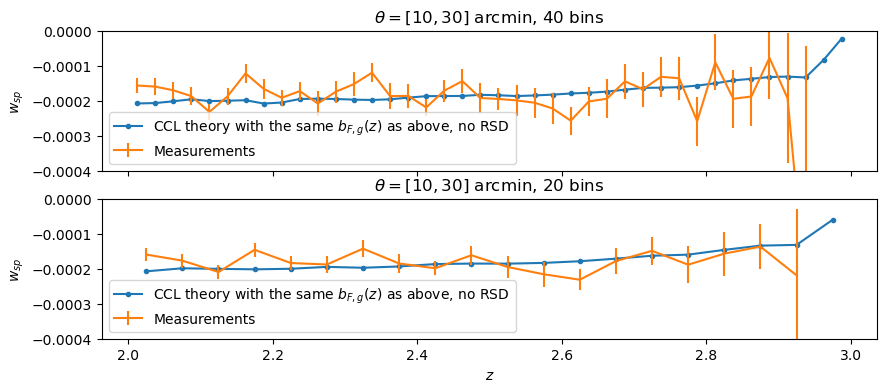

In [136]:
fig,axarr=pl.subplots(2,figsize=[10,4],sharex=True)
pl.sca(axarr[0])
pl.plot(zbins, w_sp,'.-',label="CCL theory with the same $b_{F,g}(z)$ as above, no RSD")
pl.errorbar(data_wsp[:,0], data_wsp[:,1],yerr=data_wsp[:,2],label="Measurements")
pl.ylim([-0.0004,0.0000])
pl.ylabel("$w_{sp}$")
pl.legend()
pl.title("$\\theta=[10,30]$ arcmin, 40 bins")

pl.sca(axarr[1])
pl.plot(zbins20, w_sp20,'.-',label="CCL theory with the same $b_{F,g}(z)$ as above, no RSD")
pl.errorbar(data_wsp20[:,0], data_wsp20[:,1],yerr=data_wsp20[:,2],label="Measurements")
pl.ylabel("$w_{sp}$")
pl.legend()
pl.title("$\\theta=[10,30]$ arcmin, 20 bins")
pl.xlabel("$z$")
pl.ylim([-0.0004,0.0000])

In [15]:
# ell conversion
z = np.linspace(2,3,20)
d = ccl.comoving_radial_distance(cosmo_ccl, 1/(1+z))

theta_min = 10/60/180*np.pi # arcmin -> rad
theta_max = 30/60/180*np.pi # arcmin -> rad

print(d*theta_min*h)
print(d*theta_max*h)

[10.41559043 10.56517605 10.71120972 10.85382122 10.9931357  11.1292715
 11.26234084 11.39245344 11.51971136 11.64421241 11.76605143 11.88531857
 12.00209939 12.11647587 12.22852654 12.33832659 12.445948   12.5514597
 12.6549277  12.75641526]
[31.24677129 31.69552814 32.13362915 32.56146367 32.9794071  33.3878145
 33.78702253 34.17736033 34.55913408 34.93263723 35.2981543  35.65595572
 36.00629816 36.3494276  36.68557961 37.01497977 37.33784401 37.6543791
 37.96478309 38.26924577]


In [16]:
theta_min

0.0029088820866572155

# Measure $C_{\ell}$

In [5]:
# load galaxies:
saveroot = "/pscratch/sd/q/qhang/desi-lya/results/run-0/"
path_unknown = saveroot + "catalogue/unknown-zmin-1.8-zmax-3.0.fits"
fin = fits.open(path_unknown)
nside=1024
npix = int(12*nside**2)
mask = hp.read_map("/pscratch/sd/q/qhang/desi-lya/desixlsst-mask-nside-128.fits")
mask = hp.ud_grade(mask, nside)
fsky = np.mean(mask)

In [8]:
fin[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   24 / length of dimension 1                          
NAXIS2  =            110938487 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    3 / number of table fields                         
TTYPE1  = 'RA      '                                                            
TFORM1  = 'D       '                                                            
TTYPE2  = 'DEC     '                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'Z       '        

In [6]:
# make maps in bins:
nbins = 20
edges = np.linspace(2,3,nbins+1)
C_ell_holder = np.zeros((3*nside, nbins))
pshot = np.zeros(nbins)
zsamp = np.linspace(1.8,3.0,201)
nofz = np.zeros((len(zsamp)-1, nbins+1))
ind_to_plot = [0,5,10,15,18]

#for ii in range(nbins):
for ii in ind_to_plot:
    sel = (fin[1].data['Z']>edges[ii])&(fin[1].data['Z']<=edges[ii+1])
    #pix = hp.ang2pix(nside, np.radians(90 - fin[1].data['DEC'][sel]), np.radians(fin[1].data['RA'][sel]))
    #pix = hp.ang2pix(nside, fin[1].data['RA'][sel], fin[1].data['DEC'][sel], lonlat=True)
    #galmap = np.bincount(pix, minlength=npix)

    nofz[:,ii], ig = np.histogram(fin[1].data['Z'][sel], bins=zsamp)

    # measure C_ell's 
    #Ngal = sum(galmap)
    #pshot[ii] = np.pi*4*fsky/Ngal
    #densmap = (galmap/(sum(galmap)/sum(mask))-1)*mask
    #C_ell_holder[:,ii] = hp.anafast(densmap, lmax=3*nside-1)/fsky # pseudo cell correction

In [7]:
# get ccl theory fit:
Cell_pp_fitted = np.zeros((3*nside, nbins))
zz = (zsamp[1:] + zsamp[:-1])/2.
bz_interp = np.interp(zz, bias_z[:,0], bias_z[:,1])
wpp_fitted = np.zeros(nbins)
ell = np.arange(3*nside)
theta = np.linspace(10/60, 30/60, 10)#degrees
for ii in ind_to_plot:
    #zsamp_lyaf = np.linspace(edges[ii],edges[ii+1],50)
    dz = zz[1]-zz[0]
    #nz_lyaf = np.ones(len(zsamp_lyaf))
    nz = nofz[:,ii]
    nz = nz/sum(nz)/dz
    
    clu2 = ccl.NumberCountsTracer(cosmo_ccl, has_rsd=False, dndz=(zz, nz), 
                                          bias=(zz, bz_interp))

    cell=ccl.angular_cl(cosmo_ccl, clu2, clu2, np.arange(3*nside))
    w1 = ccl.correlations.correlation(cosmo_ccl, ell=ell, C_ell=cell, theta=theta)
    wpp_fitted[ii] = np.mean(w1)
    Cell_pp_fitted[:,ii] = cell

(0.0, 0.3)

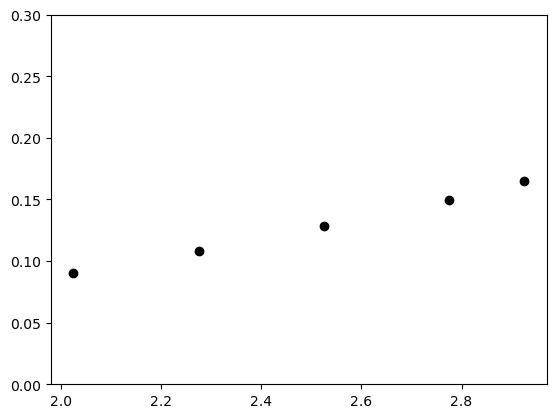

In [18]:
for ii in ind_to_plot:
    pl.plot((edges[ii]+edges[ii+1])/2., wpp_fitted[ii], 'ko')
pl.ylim([0,0.3])

In [64]:
# save these:
np.savetxt("cell-pp-baseline-20bin.txt", C_ell_holder)
np.savetxt("pshot-pp-baseline-20bin.txt", pshot)
np.savetxt("cell-pp-theory-baseline-20bin.txt", Cell_pp_fitted)

In [23]:
C_ell_holder = np.loadtxt("cell-pp-baseline-20bin.txt")
pshot = np.loadtxt("pshot-pp-baseline-20bin.txt")
Cell_pp_fitted = np.loadtxt("cell-pp-theory-baseline-20bin.txt")
nbins = 20
edges = np.linspace(2,3,nbins+1)
theta = np.array([10,30]) # arcmin

In [9]:
# rough ell estimate:
ell_scale = 180/(theta/60)
print(ell_scale)

[1080.  360.]


In [10]:
pshot

array([2.55085658e-07, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.41444066e-07, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 4.18507069e-07, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.51363857e-07,
       0.00000000e+00, 0.00000000e+00, 7.33912245e-07, 0.00000000e+00])

2.0 2.05
2.4410067680870196
2.25 2.3
2.835202733482439
2.5 2.55
3.2726705818103845
2.75 2.8
3.753410313070857
2.9 2.95
4.062699549278289


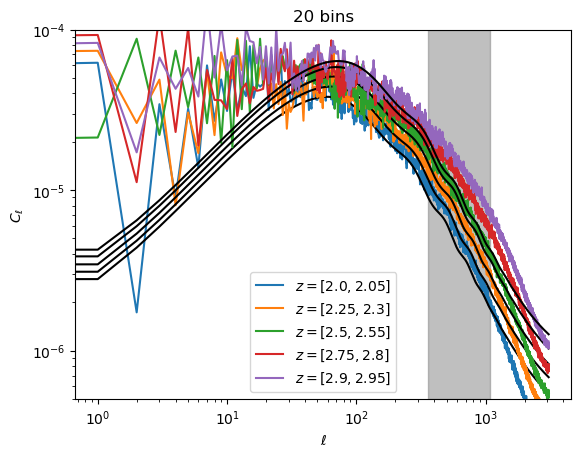

In [24]:
nside=1024
ind_to_plot = [0,5,10,15,18]
for ind in ind_to_plot:
    print(edges[ind], edges[ind+1])
    bias_ind = np.interp((edges[ind]+edges[ind+1])/2., bias_z[:,0],  bias_z[:,1])
    print(bias_ind)
    pl.plot(np.arange(3*nside), C_ell_holder[:,ind],label=f"$z=[{edges[ind]},{edges[ind+1]}]$")
    pl.plot(np.arange(3*nside), Cell_pp_fitted[:,ind]+ pshot[ind], color='k')
pl.axvspan(360, 1080, alpha=0.5, color='grey')
pl.ylim([5e-7,1e-4])
pl.yscale('log')
#pl.xscale('log')
pl.xlabel("$\\ell$")
pl.ylabel("$C_{\\ell}$")
pl.legend()
pl.title("20 bins")
#pl.xlim([0,2500])
pl.xscale("log")

/tmp/ipykernel_2356424/2791780347.py:7: RuntimeWarning: invalid value encountered in sqrt
  pl.plot(np.arange(3*nside), np.sqrt(ratio),label=f"$z=[{edges[ind]},{edges[ind+1]}]$")


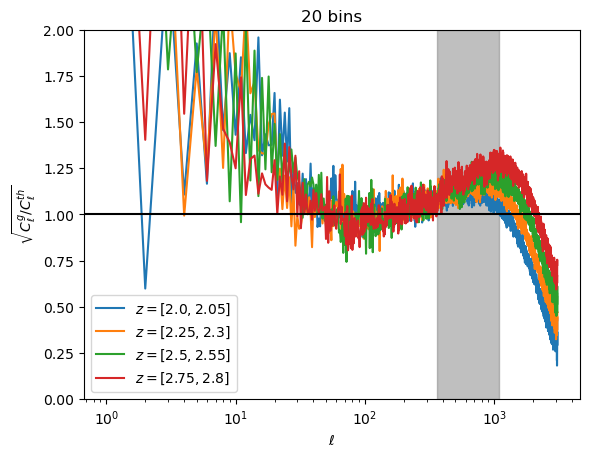

In [25]:
# let's try to fit the bias:
#ind_to_plot = [0,5,10,15,18]
ind_to_plot=[0,5,10,15]
for ind in ind_to_plot:
    bias_ind = np.interp((edges[ind]+edges[ind+1])/2., bias_z[:,0],  bias_z[:,1])
    ratio = (C_ell_holder[:,ind] - pshot[ind])/Cell_pp_fitted[:,ind]
    pl.plot(np.arange(3*nside), np.sqrt(ratio),label=f"$z=[{edges[ind]},{edges[ind+1]}]$")
pl.ylim([0,2])
pl.xlabel("$\\ell$")
pl.ylabel("$\\sqrt{C_{\\ell}^g/C_{\\ell}^{th}}$")
pl.axvspan(360, 1080, alpha=0.5, color='grey')
pl.title("20 bins")
pl.axhline(y=1, color='k', linestyle='-')
#pl.xlim([0,2500])
pl.legend()
pl.xscale('log')

Bias roughly matches input values at large scales, but is much smaller at small scales; 
Bias is very scale dependent which is kind of known for exponential bias models;

Question 1: what is the scales are we probing

Question 2: does this change as we go to thin shells?

In [11]:
# make maps in bins:
nside=1024
nbins = 40
edges = np.linspace(2,3,nbins+1)
C_ell_holder40 = np.zeros((3*nside, nbins))
npix = int(12*nside**2)
pshot40 = np.zeros(nbins)
ind_to_plot = [0,10,20,30,39]
zsamp = np.linspace(1.8,3.0,201)
nofz40 = np.zeros((len(zsamp)-1, nbins+1))

#for ii in range(nbins):
for ii in ind_to_plot:
    sel = (fin[1].data['Z']>edges[ii])&(fin[1].data['Z']<=edges[ii+1])
    #pix = hp.ang2pix(nside, fin[1].data['RA'][sel], fin[1].data['DEC'][sel], lonlat=True)
    #galmap = np.bincount(pix, minlength=npix)
    nofz40[:,ii], ig = np.histogram(fin[1].data['Z'][sel], bins=zsamp)

    # measure C_ell's 
    #Ngal = sum(galmap)
    #pshot40[ii] = np.pi*4*fsky/Ngal
    #densmap = (galmap/(sum(galmap)/sum(mask))-1)*mask
    #C_ell_holder40[:,ii] = hp.anafast(densmap, lmax=3*nside-1)/fsky # pseudo cell correction

In [12]:
# get ccl theory fit:
nbins = 40
edges = np.linspace(2,3,nbins+1)
zsamp = np.linspace(1.8,3.0,201)
Cell_pp_fitted40 = np.zeros((3*nside, nbins))
zz = (zsamp[1:] + zsamp[:-1])/2.
bz_interp = np.interp(zz, bias_z[:,0], bias_z[:,1])
wpp_fitted40 = np.zeros(nbins)
ell = np.arange(3*nside)
theta = np.linspace(10/60, 30/60, 10)#degrees
ind_to_plot = [0,10,20,30,39]
for ii in ind_to_plot:
    #zsamp_lyaf = np.linspace(edges[ii],edges[ii+1],50)
    dz = zz[1]-zz[0]
    #nz_lyaf = np.ones(len(zsamp_lyaf))
    nz = nofz40[:,ii]
    nz = nz/sum(nz)/dz
    
    clu2 = ccl.NumberCountsTracer(cosmo_ccl, has_rsd=False, dndz=(zz, nz), 
                                          bias=(zz, bz_interp))

    cell=ccl.angular_cl(cosmo_ccl, clu2, clu2, np.arange(3*nside))

    w1 = ccl.correlations.correlation(cosmo_ccl, ell=ell, C_ell=cell, theta=theta)
    wpp_fitted40[ii] = np.mean(w1)
    Cell_pp_fitted40[:,ii] = cell

(0.0, 0.3)

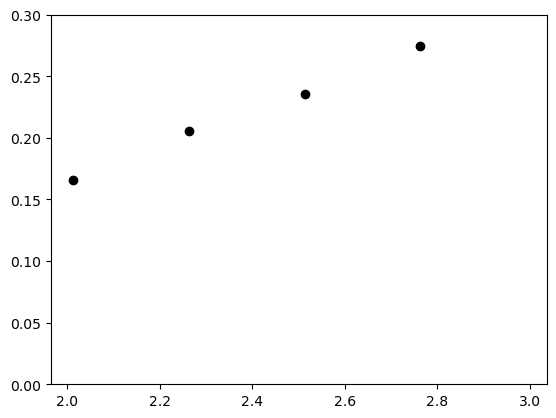

In [15]:
for ii in ind_to_plot:
    pl.plot((edges[ii]+edges[ii+1])/2., wpp_fitted40[ii], 'ko')
pl.ylim([0,0.3])

In [9]:
# save these:
np.savetxt("cell-pp-baseline-40bin.txt", C_ell_holder40)
np.savetxt("pshot-pp-baseline-40bin.txt", pshot40)
np.savetxt("cell-pp-theory-baseline-40bin.txt", Cell_pp_fitted40)

In [26]:
C_ell_holder40 = np.loadtxt("cell-pp-baseline-40bin.txt")
pshot40 = np.loadtxt("pshot-pp-baseline-40bin.txt")
Cell_pp_fitted40 = np.loadtxt("cell-pp-theory-baseline-40bin.txt")
nbins = 40
edges = np.linspace(2,3,nbins+1)
theta = np.array([10,30]) # arcmin

2.0 2.025
2.4222539441513335
2.25 2.275
2.8143695305596124
2.5 2.525
3.249756999900417
2.75 2.775
3.728416352173749
2.975 3.0
4.158294831773159


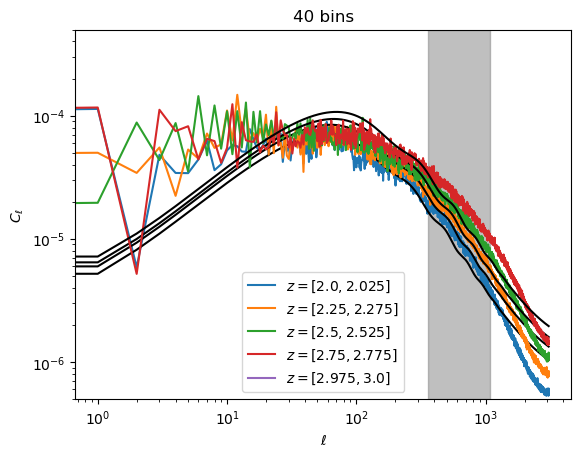

In [20]:
# plot some of them:
nside=1024
ind_to_plot = [0,10,20,30,39]
for ind in ind_to_plot:
    print(edges[ind], edges[ind+1])
    bias_ind = np.interp((edges[ind]+edges[ind+1])/2., bias_z[:,0],  bias_z[:,1])
    print(bias_ind)
    pl.plot(np.arange(3*nside), C_ell_holder40[:,ind],label=f"$z=[{edges[ind]},{edges[ind+1]}]$")
    pl.plot(np.arange(3*nside), Cell_pp_fitted40[:,ind]+ pshot40[ind], color='k')
pl.axvspan(360, 1080, alpha=0.5, color='grey')
pl.ylim([5e-7,5e-4])
pl.yscale('log')
#pl.xscale('log')
pl.xlabel("$\\ell$")
pl.ylabel("$C_{\\ell}$")
pl.legend()
pl.title("40 bins")
#pl.xlim([0,2500])
pl.xscale("log")

/tmp/ipykernel_2356424/2126240453.py:6: RuntimeWarning: invalid value encountered in sqrt
  pl.plot(np.arange(3*nside), np.sqrt(ratio),label=f"$z=[{edges[ind]},{edges[ind+1]}]$")


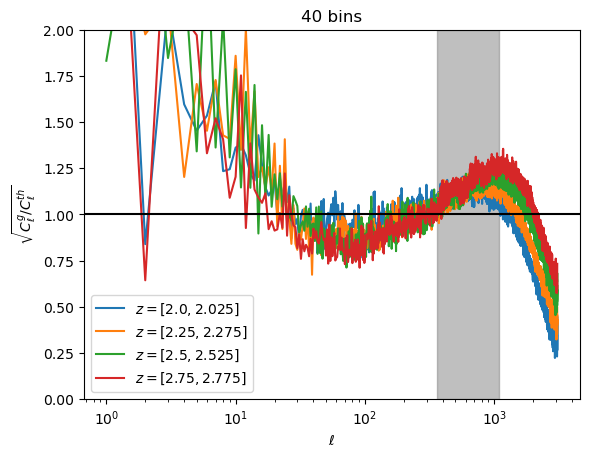

In [28]:
# let's try to fit the bias:
ind_to_plot = [0,10,20,30,39]
for ind in ind_to_plot[:-1]:
    bias_ind = np.interp((edges[ind]+edges[ind+1])/2., bias_z[:,0],  bias_z[:,1])
    ratio = (C_ell_holder40[:,ind] - pshot40[ind])/Cell_pp_fitted40[:,ind]
    pl.plot(np.arange(3*nside), np.sqrt(ratio),label=f"$z=[{edges[ind]},{edges[ind+1]}]$")
pl.ylim([0,2])
pl.xlabel("$\\ell$")
pl.ylabel("$\\sqrt{C_{\\ell}^g/C_{\\ell}^{th}}$")
pl.axvspan(360, 1080, alpha=0.5, color='grey')
pl.title("40 bins")
pl.axhline(y=1, color='k', linestyle='-')
#pl.xlim([0,2500])
pl.legend()
pl.xscale("log")

Test 10 bin

In [24]:
# make maps in bins:
nside=1024
nbins = 10
edges = np.linspace(2,3,nbins+1)
C_ell_holder10 = np.zeros((3*nside, nbins))
npix = int(12*nside**2)
pshot10 = np.zeros(nbins)
ind_to_plot = [0,2,4,6,8]
zsamp = np.linspace(1.8,3.0,201)
nofz10 = np.zeros((len(zsamp)-1, nbins+1))

#for ii in range(nbins):
for ii in ind_to_plot:
    sel = (fin[1].data['Z']>edges[ii])&(fin[1].data['Z']<=edges[ii+1])
    pix = hp.ang2pix(nside, fin[1].data['RA'][sel], fin[1].data['DEC'][sel], lonlat=True)
    galmap = np.bincount(pix, minlength=npix)
    nofz10[:,ii], ig = np.histogram(fin[1].data['Z'][sel], bins=zsamp)

    # measure C_ell's 
    Ngal = sum(galmap)
    pshot10[ii] = np.pi*4*fsky/Ngal
    densmap = (galmap/(sum(galmap)/sum(mask))-1)*mask
    C_ell_holder10[:,ii] = hp.anafast(densmap, lmax=3*nside-1)/fsky # pseudo cell correction

In [30]:
edges

array([2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. ])

In [25]:
# get ccl theory fit:
Cell_pp_fitted10 = np.zeros((3*nside, nbins))
zz = (zsamp[1:] + zsamp[:-1])/2.
bz_interp = np.interp(zz, bias_z[:,0], bias_z[:,1])
for ii in ind_to_plot:
    #zsamp_lyaf = np.linspace(edges[ii],edges[ii+1],50)
    dz = zz[1]-zz[0]
    #nz_lyaf = np.ones(len(zsamp_lyaf))
    nz = nofz10[:,ii]
    nz = nz/sum(nz)/dz
    
    clu2 = ccl.NumberCountsTracer(cosmo_ccl, has_rsd=False, dndz=(zz, nz), 
                                          bias=(zz, bz_interp))

    cell=ccl.angular_cl(cosmo_ccl, clu2, clu2, np.arange(3*nside))
    Cell_pp_fitted10[:,ii] = cell

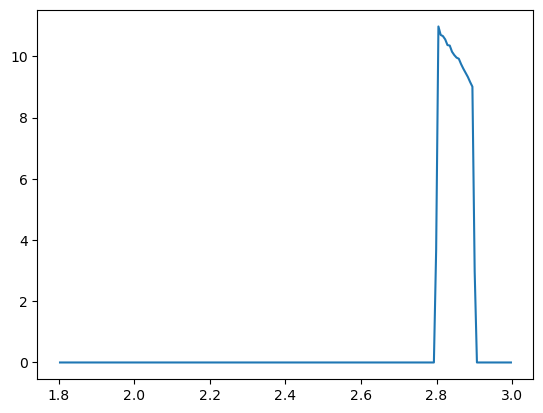

In [28]:
pl.plot(zz, nz)

In [26]:
# save these:
np.savetxt("cell-pp-baseline-10bin.txt", C_ell_holder10)
np.savetxt("pshot-pp-baseline-10bin.txt", pshot10)
np.savetxt("cell-pp-theory-baseline-10bin.txt", Cell_pp_fitted10)

In [29]:
C_ell_holder10 = np.loadtxt("cell-pp-baseline-10bin.txt")
pshot10 = np.loadtxt("pshot-pp-baseline-10bin.txt")
Cell_pp_fitted10 = np.loadtxt("cell-pp-theory-baseline-10bin.txt")
nbins = 10
edges = np.linspace(2,3,nbins+1)
theta = np.array([10,30]) # arcmin

2.0 2.1
2.478512415958392
2.2 2.3
2.7935363276367853
2.4 2.5
3.136853393540292
2.6 2.7
3.507631462074056


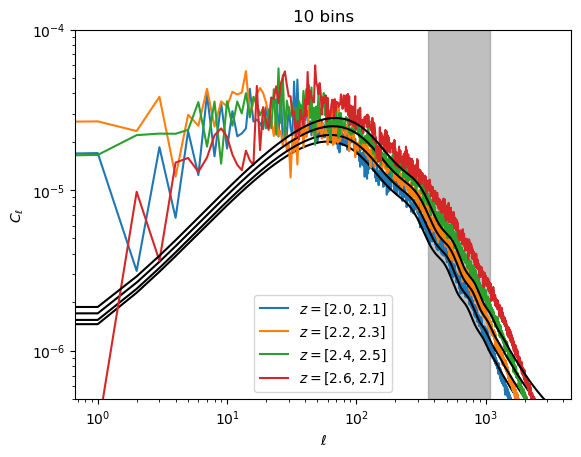

In [32]:
# plot some of them:
nside=1024
ind_to_plot = [0,2,4,6]#,8]
for ind in ind_to_plot:
    print(edges[ind], edges[ind+1])
    bias_ind = np.interp((edges[ind]+edges[ind+1])/2., bias_z[:,0],  bias_z[:,1])
    print(bias_ind)
    pl.plot(np.arange(3*nside), C_ell_holder10[:,ind],label=f"$z=[{edges[ind]},{edges[ind+1]}]$")
    pl.plot(np.arange(3*nside), Cell_pp_fitted10[:,ind]+ pshot10[ind], color='k')
pl.axvspan(360, 1080, alpha=0.5, color='grey')
pl.ylim([5e-7,1e-4])
pl.yscale('log')
#pl.xscale('log')
pl.xlabel("$\\ell$")
pl.ylabel("$C_{\\ell}$")
pl.legend()
pl.title("10 bins")
#pl.xlim([0,2500])
pl.xscale('log')

/tmp/ipykernel_2356424/428498931.py:5: RuntimeWarning: invalid value encountered in sqrt
  pl.plot(np.arange(3*nside), np.sqrt(ratio),label=f"$z=[{edges[ind]},{edges[ind+1]}]$")


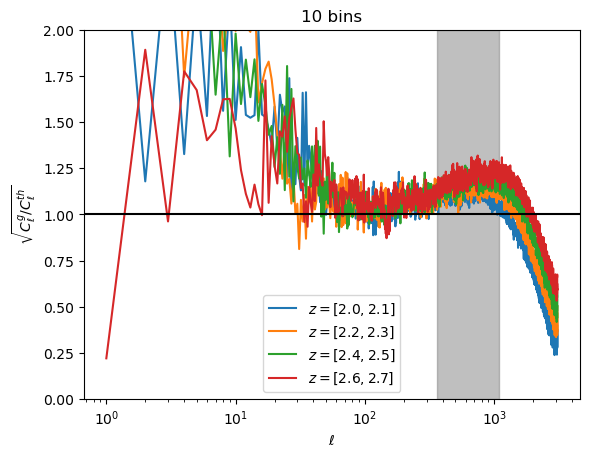

In [33]:
# let's try to fit the bias:
for ind in ind_to_plot:
    bias_ind = np.interp((edges[ind]+edges[ind+1])/2., bias_z[:,0],  bias_z[:,1])
    ratio = (C_ell_holder10[:,ind] - pshot10[ind])/Cell_pp_fitted10[:,ind]
    pl.plot(np.arange(3*nside), np.sqrt(ratio),label=f"$z=[{edges[ind]},{edges[ind+1]}]$")
pl.ylim([0,2])
pl.xlabel("$\\ell$")
pl.ylabel("$\\sqrt{C_{\\ell}^g/C_{\\ell}^{th}}$")
pl.axvspan(360, 1080, alpha=0.5, color='grey')
pl.title("10 bins")
pl.axhline(y=1, color='k', linestyle='-')
#pl.xlim([0,2500])
pl.legend()
pl.xscale('log')